# Importing packages

In [1]:
import pandas as pd
import numpy as np
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.decomposition import PCA

# Extracting data and selected features

In [2]:
df = pd.read_parquet('/kaggle/input/cictoniot/CIC-ToN-IoT-V2.parquet')

In [3]:
features = ['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',       
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',        
       'Fwd URG Flags', 'Bwd URG Flags', 'FIN Flag Count', 'SYN Flag Count',  
       'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count',
       'CWE Flag Count', 'ECE Flag Count', 'Packet Length Min',
       'Packet Length Max', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'Fwd Packets/s', 'Bwd Packets/s',
       'Down/Up Ratio', 'Avg Packet Size', 'Avg Fwd Segment Size',
       'Avg Bwd Segment Size']

In [4]:
existing_columns = [col for col in features if col in df.columns]
print(existing_columns) 

['Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'Fwd Packets/s', 'Bwd Packets/s', 'Down/Up Ratio', 'Avg Packet Size', 'Avg Fwd Segment 

In [5]:
modified = df[existing_columns]

In [7]:
x = modified
y = df["Attack"]

In [8]:
df['Attack'].value_counts()

Attack
Benign        2123867
xss           2057122
password       328648
injection      269499
scanning        35564
backdoor        27145
ransomware       4790
mitm              517
ddos              202
dos               145
Name: count, dtype: int64

# Solving imbalanced data 
### as it's obvious the data has a large imbalance which will led to bad results so , we did a data balancing with down sampling the really major classes using ( **NearMiss** ) and oversampling using (**SMOTE**)

In [9]:
under_sampled = {'Benign' : 1000000 , 'xss' : 1000000, 'password': 25000 , 'injection':25000}

cc = NearMiss(sampling_strategy=under_sampled)
x ,y = cc.fit_resample(x ,y)

In [10]:
over_sampled = {'scanning':60000 , 'backdoor' : 60000 , 'ransomware' : 60000 , 'mitm' : 60000 , 'ddos' : 25000 , 'dos' : 60000}

sm = SMOTE(sampling_strategy=over_sampled)
x , y = sm.fit_resample(x , y)

In [11]:
y.value_counts()

Attack
Benign        1000000
xss           1000000
backdoor        60000
dos             60000
ransomware      60000
mitm            60000
scanning        60000
ddos            25000
injection       25000
password        25000
Name: count, dtype: int64

In [12]:
oversampled_data = pd.DataFrame(x, columns=x.columns)
oversampled_data['Attack'] = y

oversampled_data.to_csv('oversampled_data.csv', index=False)

In [15]:
data = oversampled_data
data.head()


,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Packet Length Mean,Packet Length Std,Packet Length Variance,Fwd Packets/s,Bwd Packets/s,Down/Up Ratio,Avg Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Attack
0,17,12609,2,2,84.0,424.0,42.0,42.0,42.0,0.0,...,110.000000,93.498665,8742.000000,158.616867,158.616867,1.0,137.5,42.0,212.0,Benign
1,17,12908,2,2,84.0,424.0,42.0,42.0,42.0,0.0,...,110.000000,93.498665,8742.000000,154.942673,154.942673,1.0,137.5,42.0,212.0,Benign
2,17,3152,2,2,84.0,436.0,42.0,42.0,42.0,0.0,...,112.400002,96.771896,9364.799805,634.517761,634.517761,1.0,140.5,42.0,218.0,Benign
3,17,12847,1,1,47.0,99.0,47.0,47.0,47.0,0.0,...,64.333336,30.022215,901.333313,77.839188,77.839188,1.0,96.5,47.0,99.0,Benign
4,17,12867,1,1,44.0,105.0,44.0,44.0,44.0,0.0,...,64.333336,35.218365,1240.333374,77.718193,77.718193,1.0,96.5,44.0,105.0,Benign


# Visulaization

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_30/2841543727.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, 3)


Basic Statistics:
           Protocol  Flow Duration  Total Fwd Packets  Total Backward Packets  \
count  2.375000e+06   2.375000e+06       2.375000e+06            2.375000e+06   
mean   9.281217e+00   1.211132e+06       4.854302e+00            3.957469e+00   
std    5.043337e+00   8.685079e+06       6.882494e+01            3.814696e+01   
min    0.000000e+00  -3.174227e+09       1.000000e+00            0.000000e+00   
25%    6.000000e+00   5.190000e+02       1.000000e+00            1.000000e+00   
50%    6.000000e+00   3.481000e+03       2.000000e+00            1.000000e+00   
75%    1.700000e+01   1.279000e+04       2.000000e+00            2.000000e+00   
max    1.700000e+01   1.200000e+08       6.134000e+03            4.347000e+03   

       Fwd Packets Length Total  Bwd Packets Length Total  \
count              2.375000e+06              2.375000e+06   
mean               5.492393e+02              1.644626e+03   
std                1.354211e+04              2.756440e+04   
min     

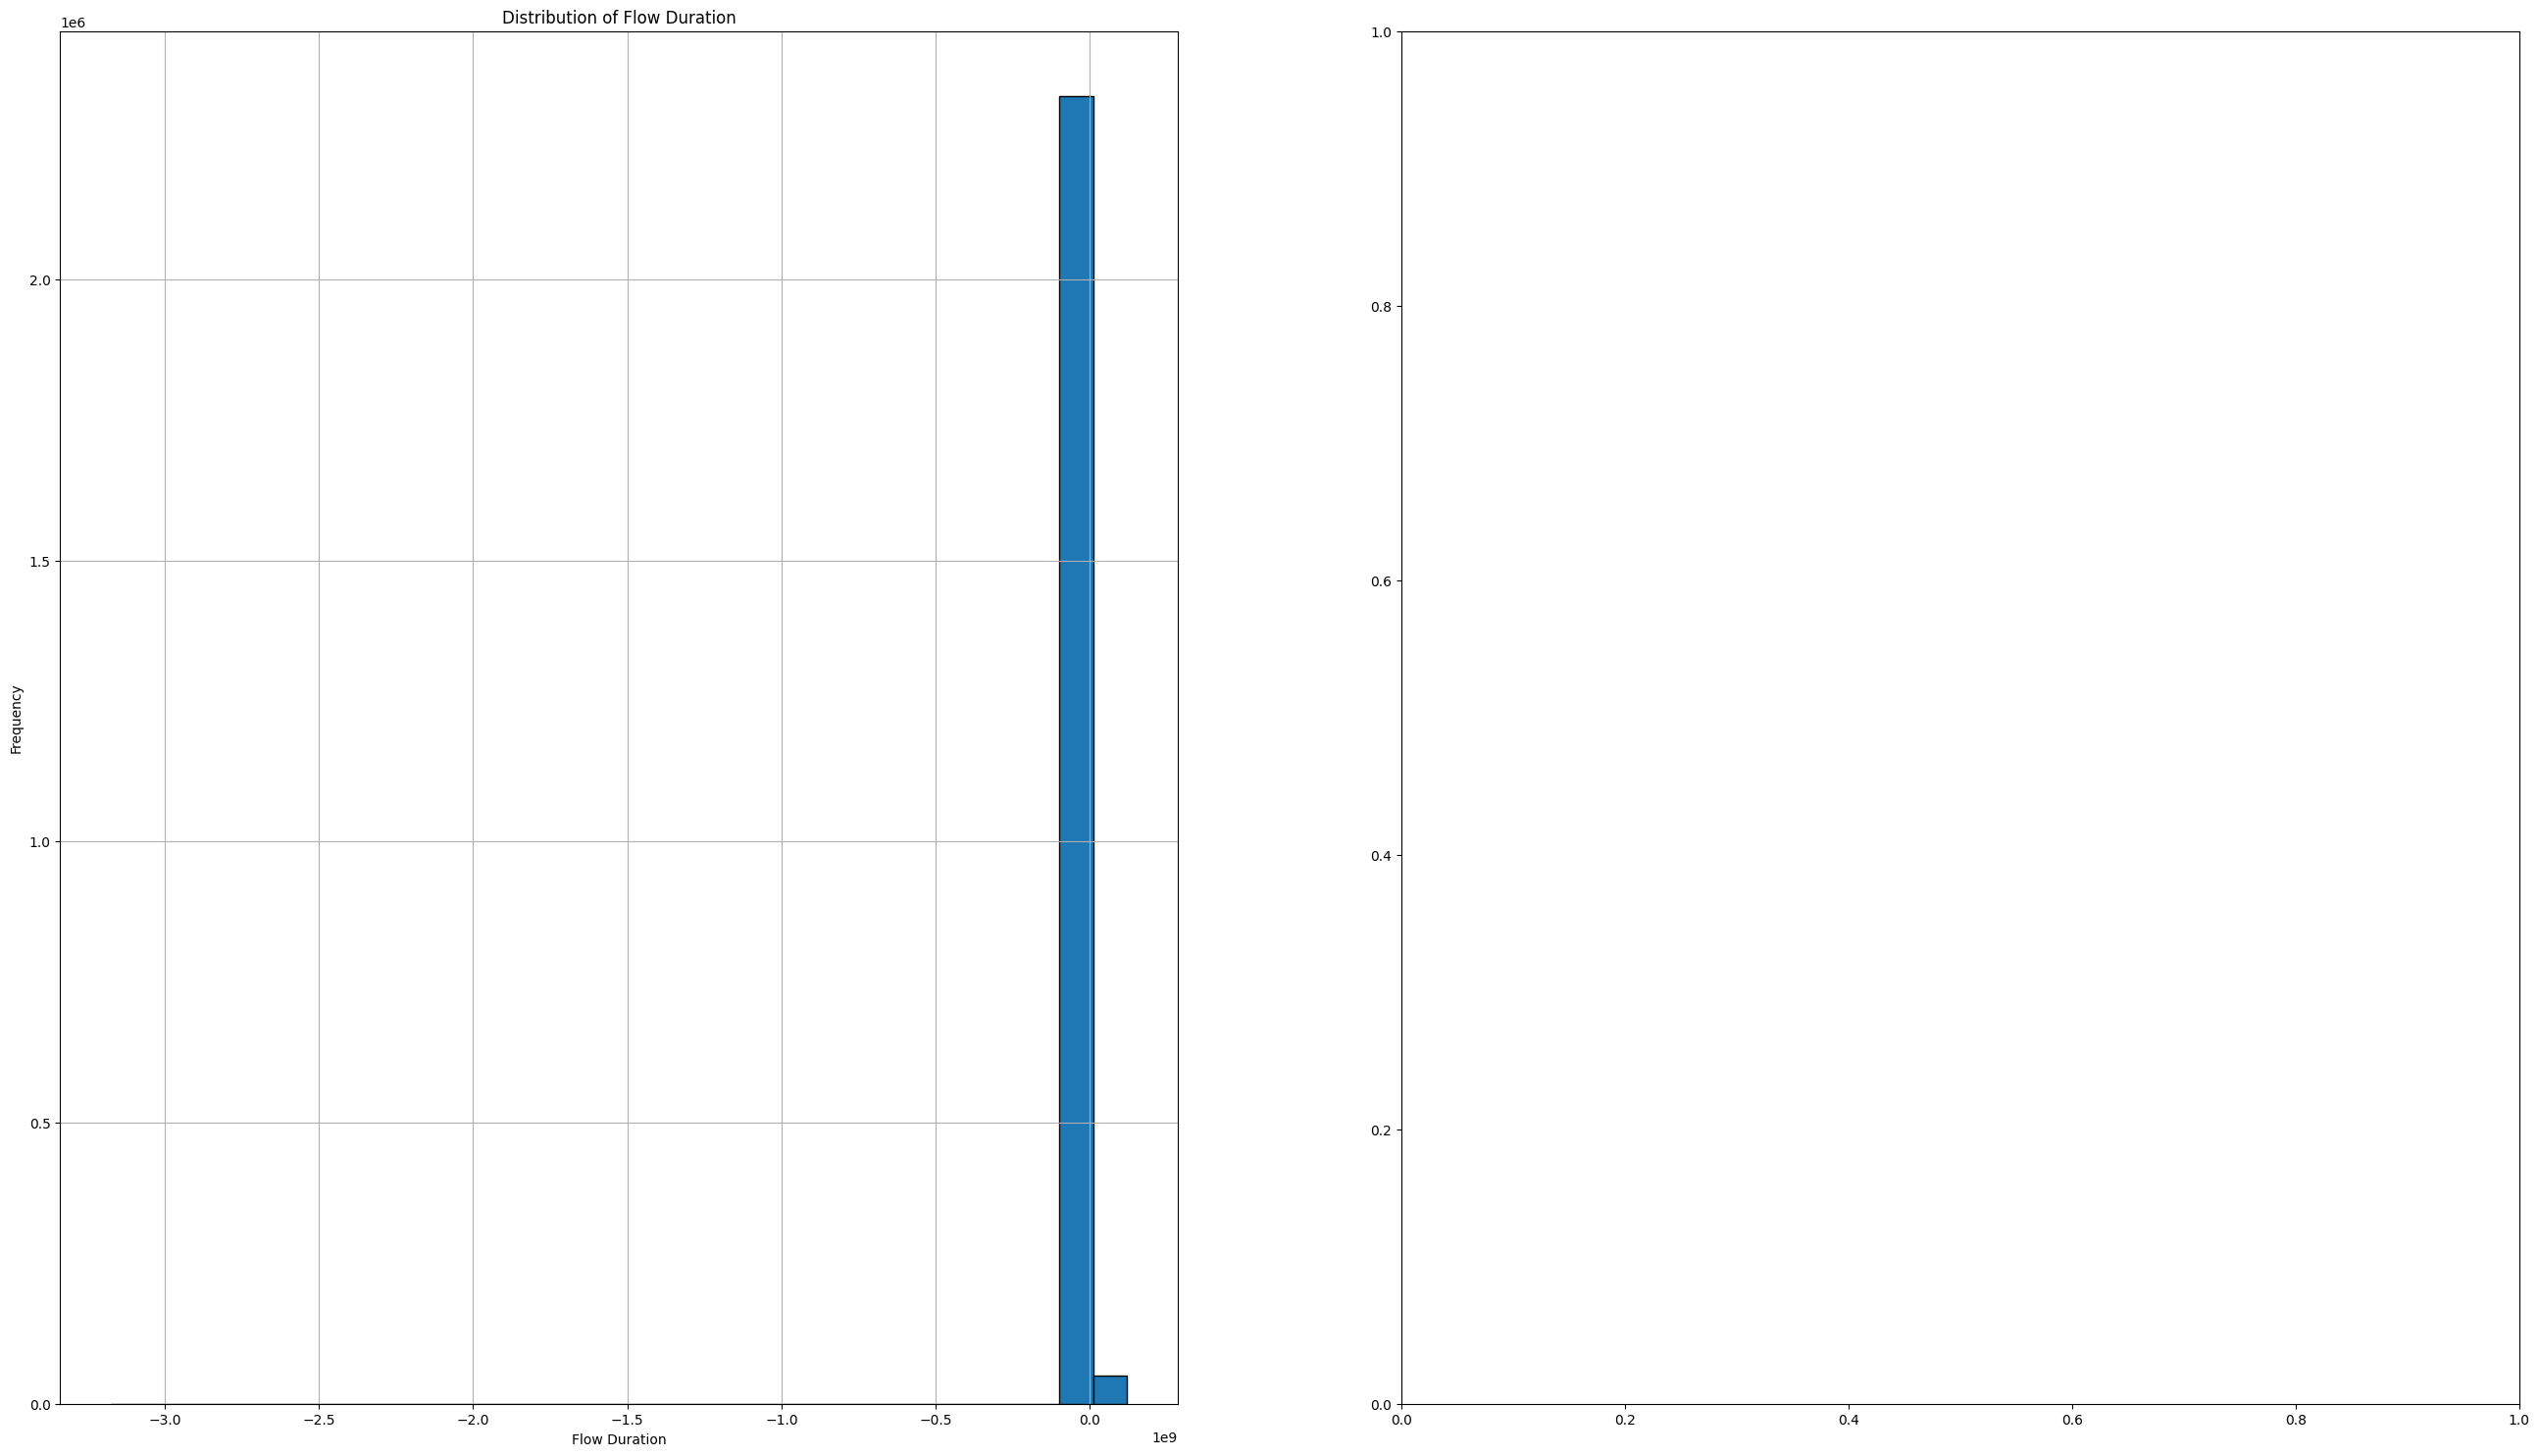

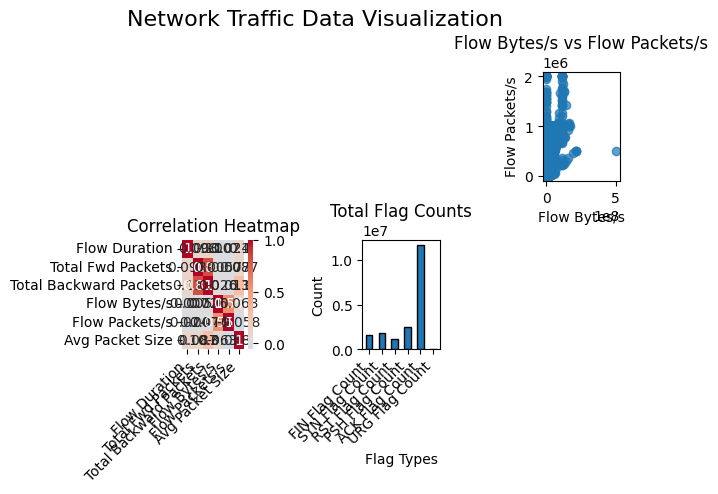

In [19]:
plt.figure(figsize=(50, 40))


plt.subplot(2, 3, 1)
data['Flow Duration'].hist(bins=30, edgecolor='black')
plt.title('Distribution of Flow Duration')
plt.xlabel('Flow Duration')
plt.ylabel('Frequency')


plt.subplot(2, 3, 2)
data[['Fwd Packet Length Max', 'Fwd Packet Length Min', 
    'Bwd Packet Length Max', 'Bwd Packet Length Min']].plot(kind='box')
plt.title('Packet Length Variations')
plt.ylabel('Packet Length')
plt.xticks(rotation=45, ha='right')

# 3. Scatter Plot of Flow Bytes/s vs Flow Packets/s
plt.subplot(2, 3, 3)
plt.scatter(data['Flow Bytes/s'], data['Flow Packets/s'], alpha=0.7)
plt.title('Flow Bytes/s vs Flow Packets/s')
plt.xlabel('Flow Bytes/s')
plt.ylabel('Flow Packets/s')


plt.subplot(2, 3, 4)
correlation_columns = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 
                       'Flow Bytes/s', 'Flow Packets/s', 'Avg Packet Size']
correlation_matrix = data[correlation_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# 5. Bar Plot of Flag Counts
plt.subplot(2, 3, 5)
flag_columns = ['FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 
                'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count']
data[flag_columns].sum().plot(kind='bar', edgecolor='black')
plt.title('Total Flag Counts')
plt.xlabel('Flag Types')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')


# Adjust layout and save
plt.tight_layout()
plt.suptitle('Network Traffic Data Visualization', fontsize=16, y=1.02)
plt.savefig('network_traffic_visualization.png', dpi=300, bbox_inches='tight')

# Print some basic statistics
print("Basic Statistics:")
print(data.describe())

# Additional Insights
print("\nAdditional Insights:")
print("Unique Protocols:", df['Protocol'].unique())
print("Total number of records:", len(df))

In [ ]:

from scipy import stats


# Create a comprehensive figure with multiple subplots
plt.figure(figsize=(25, 20))

# 1. Advanced Flow Duration Analysis
plt.subplot(3, 4, 1)
sns.histplot(data['Flow Duration'], kde=True)
plt.title('Flow Duration Distribution')
plt.xlabel('Flow Duration')
plt.ylabel('Frequency')

# 2. Detailed Packet Length Comparison
plt.subplot(3, 4, 2)
packet_length_cols = [
    'Fwd Packet Length Mean', 'Fwd Packet Length Max', 'Fwd Packet Length Min',
    'Bwd Packet Length Mean', 'Bwd Packet Length Max', 'Bwd Packet Length Min'
]
data[packet_length_cols].boxplot()
plt.title('Detailed Packet Length Statistics')
plt.xticks(rotation=45, ha='right')

# 3. Comprehensive Correlation Heatmap
plt.subplot(3, 4, 3)
selected_columns = [
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 
    'Fwd Packets Length Total', 'Bwd Packets Length Total',
    'Flow Bytes/s', 'Flow Packets/s', 'Avg Packet Size'
]
correlation_matrix = data[selected_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Advanced Correlation Heatmap')
plt.xticks(rotation=45, ha='right')


# 6. Packet Rate Comparison
plt.subplot(3, 4, 6)
packet_rate_cols = ['Fwd Packets/s', 'Bwd Packets/s']
data[packet_rate_cols].plot(kind='kde')
plt.title('Forward vs Backward Packet Rates')
plt.xlabel('Packets per Second')

# 7. Scatter Plot with Density Coloring
plt.subplot(3, 4, 7)
plt.hexbin(data['Flow Bytes/s'], data['Avg Packet Size'], gridsize=20, cmap='YlGnBu')
plt.colorbar(label='Count')
plt.title('Flow Bytes/s vs Average Packet Size')
plt.xlabel('Flow Bytes/s')
plt.ylabel('Average Packet Size')

# 8. Distribution of Packet Length Variance
plt.subplot(3, 4, 8)
plt.hist(data['Packet Length Variance'], bins=30, edgecolor='black')
plt.title('Packet Length Variance Distribution')
plt.xlabel('Packet Length Variance')
plt.ylabel('Frequency')

# 9. Advanced Statistical Summary
plt.subplot(3, 4, 9)
numerical_cols = [
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 
    'Flow Bytes/s', 'Flow Packets/s', 'Avg Packet Size'
]
stats_data = data[numerical_cols].agg(['mean', 'median', 'std', 'skew'])
stats_data.T.plot(kind='bar', edgecolor='black')
plt.title('Statistical Measures')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Statistic', bbox_to_anchor=(1.05, 1), loc='upper left')

# 10. Protocol Distribution Pie Chart
plt.subplot(3, 4, 10)
protocol_counts = data['Protocol'].value_counts()
plt.pie(protocol_counts, labels=protocol_counts.index, autopct='%1.1f%%')
plt.title('Protocol Distribution')



# 11. Outlier Detection
plt.subplot(3, 4, 12)
def calculate_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((series < lower_bound) | (series > upper_bound)).sum()

outliers = {col: calculate_outliers(data[col]) for col in numerical_cols}
outlier_df = pd.DataFrame.from_dict(outliers, orient='index', columns=['Outlier Count'])
outlier_df.plot(kind='bar', rot=45)
plt.title('Outlier Counts')
plt.xlabel('Features')
plt.ylabel('Number of Outliers')

# Final adjustments
plt.tight_layout()
plt.suptitle('Comprehensive Network Traffic Data Analysis', fontsize=20, y=1.02)
plt.savefig('advanced_network_traffic_analysis.png', dpi=300, bbox_inches='tight')

# Print detailed statistical summary
print("Detailed Statistical Summary:")
print(data.describe())

# Additional insights and statistics
print("\nAdditional Insights:")
print("Unique Protocols:", data['Protocol'].unique())
print("Protocol Distribution:\n", protocol_counts)
print("\nNormality Test Results:")
print(normality_df)
print("\nOutlier Counts:")
print(outlier_df)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


# Encoding Labels

In [ ]:

label_encoder = LabelEncoder()
data['Attack'] = label_encoder.fit_transform(data['Attack'])

In [ ]:
len(data.columns)

In [ ]:
X = data.drop(['Attack'], axis=1).values
y = data['Attack'].values

# Data Preprocessing

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(x)

pca = PCA()
#X = pca.fit_transform(X)
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)



device = "cuda" if torch.cuda.is_available() else "cpu"

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

In [ ]:
class AttackDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]



# Create datasets
train_dataset = AttackDataset(X_train, y_train)
test_dataset = AttackDataset(X_test, y_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Creating model 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualEnhancedNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.5):
        super(ResidualEnhancedNeuralNet, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.hidden_layer1 = nn.Linear(hidden_size, hidden_size)
        self.hidden_layer2 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.activation = nn.ReLU()

    def forward(self, x):
        # Input to first layer
        x = self.activation(self.bn1(self.input_layer(x)))

        # Residual connection 1
        residual = x
        x = self.activation(self.hidden_layer1(x))
        x = self.dropout(x)
        x += residual  # Add residual connection

        # Residual connection 2
        residual = x
        x = self.activation(self.hidden_layer2(x))
        x = self.dropout(x)
        x += residual  # Add residual connection

        # Output layer
        x = self.output_layer(x)
        return x

# Define model parameters
input_size = X_train.shape[1]
hidden_size = 256  # Increase hidden size
output_size = len(np.unique(y))
dropout_prob = 0.4  # Experiment with lower dropout

# Instantiate the model
model = ResidualEnhancedNeuralNet(input_size, hidden_size, output_size, dropout_prob).to(device)

# Training loop

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
losses_data = []
accurcies_data = []
# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
        total += labels.size(0)  # Total number of samples
        correct += (predicted == labels).sum().item()  # Correct predictions

    # Accuracy for the epoch
    accuracy = 100 * correct / total
    losses_data.append(running_loss)
    accurcies_data.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")

In [ ]:
plt.plot(losses_data)
plt.plot(accurcies_data)

# Evaluation

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

In [ ]:
torch.save(model, './model.pt')